In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from matplotlib.legend_handler import HandlerLine2D
from matplotlib.colors import LogNorm
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.cm, matplotlib.colors

import sys

import numpy as np

# ifarm batch job related import and env setup
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [2]:
datapath = '../../devel/'
events0 = np.load( datapath + 'evts-clas.npy' )

In [3]:
Mp = 0.93827
Mpi = 0.1395

In [4]:
def gamma_dist_rand(N):
    y = np.random.choice(np.arange(0, 10000), size = N, p = gamma_hist)
    y = gamma_min + (y + np.random.uniform(0, 1, N))*(gamma_max - gamma_min)/10000
    
    return(y)

In [5]:
def detector_filter(n):
    
    SAMPLE_SIZE = int( 1.60 * n )

    noise = np.random.normal(0, 1, [SAMPLE_SIZE, 100])
    gamma = gamma_dist_rand(SAMPLE_SIZE)
    gamma = (gamma - gammamean)/gammastd
    results_origin = gan.generator.predict([gamma, noise], batch_size=n)
    ppipxy = results_origin[:, [1, 2, 4, 5]]
    ppipxy = ppipxy*ppipxystd+ppipxymean

    ptheta = np.arctan2(ppipxy[:, 1], ppipxy[:, 0])
    ptheta = ptheta.reshape(-1, 1)
    piptheta = np.arctan2(ppipxy[:, 3], ppipxy[:, 2])
    piptheta = piptheta.reshape(-1, 1)
    theta = np.concatenate([ptheta, piptheta], axis=1)
    theta = np.floor(theta/np.pi*180+205)%60

    index = np.where((theta[:, 0]<=50)&(theta[:, 1]<=50))

    noise = noise[index]
    results_origin = results_origin[index]
    gamma = gamma[index]
    
    return gamma[:n], noise[:n], results_origin[:n]

In [6]:
def events_in_acceptance( arry ):
    px = arry[:, 2]
    py = arry[:, 5]
    pphi = np.arctan2(py, px)
    pphi = pphi.reshape(-1, 1)

    pipx = arry[:, 3]
    pipy = arry[:, 6]
    pipphi = np.arctan2(pipy, pipx)
    pipphi = pipphi.reshape(-1, 1)

    phi = np.concatenate([pphi, pipphi], axis=1)
    phi = np.floor(phi/np.pi*180+205)%60

    index = np.where((phi[:, 0]<=50)&(phi[:, 1]<=50))

    return arry[index]

In [7]:
def define_cms_vars( arry ):
    M2pi = arry[:, 0]
    gamma = arry[:, 1]
    px = arry[:, 2]
    py = arry[:, 5]
    pz = arry[:, 8]
    pe = arry[:, 11]
    pipx = arry[:, 3]
    pipy = arry[:, 6]
    pipz = arry[:, 9]
    pipe = arry[:, 12]
    pimx = arry[:, 4]
    pimy = arry[:, 7]
    pimz = arry[:, 10]
    pime = arry[:, 13]
    
    # Lorentz Boost to CM 
    v0 = gamma + Mp
    v3 = gamma
    v0prime = np.sqrt(v0*v0 - v3*v3)
    c = v0*v0prime/(v0*v0 - v3*v3)
    s = -c*v3/v0
    
    cmgamma = c * gamma + s * gamma
    cmprotone = c * Mp
    cmprotonz = s * Mp
    cmpe = c * pe + s * pz
    cmpx = px
    cmpy = py
    cmpz = s * pe + c * pz
    cmpipe = c * pipe + s * pipz
    cmpipx = pipx
    cmpipy = pipy
    cmpipz = s * pipe + c * pipz
    cmpime = cmgamma + cmprotone - cmpe - cmpipe
    cmpimx = pimx
    cmpimy = pimy
    cmpimz = cmgamma + cmprotonz - cmpz - cmpipz
    
    gamma = cmgamma
    protone = cmprotone
    protonz = cmprotonz
    pe = cmpe
    px = cmpx
    py = cmpy
    pz = cmpz
    pipe = cmpipe
    pipx = cmpipx
    pipy = cmpipy
    pipz = cmpipz
    pime = cmpime
    pimx = cmpimx
    pimy = cmpimy
    pimz = cmpimz
    
    events = np.stack([M2pi, gamma, px, pipx, pimx, py, pipy, pimy, pz, pipz, pimz, pe, pipe, pime], axis=1)
    
    p_pip = pe*pipe - px*pipx - py*pipy - pz*pipz
    p_pim = pe*pime - px*pimx - py*pimy - pz*pimz
    pip_pim = pipe*pime - pipx*pimx - pipy*pimy -pipz*pimz

    MMP = (gamma + protone - pe)*(gamma + protone - pe) - px*px - py*py - (gamma + protonz - pz)*(gamma + protonz - pz)
    m2pimmp = M2pi*MMP
    
    gamma_dist = gamma
    gamma_min = np.min(gamma_dist)
    gamma_max = np.max(gamma_dist)
    [gamma_hist, gamma_edges] = np.histogram(gamma_dist, bins = 10000, range=[gamma_min, gamma_max])
    
    gamma_hist = gamma_hist/gamma_dist.shape[0]
    np.save('gamma_hist.npy', gamma_hist)
    
    clas_origin = np.stack([gamma, 
                            px, py, pz, 
                            pipx, pipy, pipz, 
                            pimx, pimy, pimz, 
                            pe, pipe, pime, 
                            M2pi, p_pip, p_pim, pip_pim, MMP, m2pimmp], axis = 1)
    
    return gamma_hist, gamma_min, gamma_max, clas_origin

In [8]:
def apply_normalization( arry ):
    
    varsmean = np.mean(arry, axis = 0)
    varsstd = np.std(arry, axis = 0)
    vars = (arry - varsmean)/varsstd
    
    np.save('varsmean.npy', varsmean)
    np.save('varsstd.npy', varsstd)
    
    return varsmean, varsstd, vars

In [9]:
class LSGAN():
    def __init__(self, evt_selector=detector_filter, latent_dim=100, learning_rate=0.00001, beta1 = 0.5 ):
        self.latent_dim = latent_dim
        self.evt_selector = evt_selector
        
        self.learning_rate = learning_rate
        self.beta1 = beta1
        optimizer = Adam( learning_rate, beta1 )

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile( loss='mse',
                                    optimizer=optimizer,
                                    metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise as input and generated imgs
        generator_gamma = Input(shape=( 1, ) )
        generator_noise = Input(shape=( self.latent_dim, ) )
        evnt = self.generator( [ generator_gamma, generator_noise ] )

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator( evnt )

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model( [generator_gamma, generator_noise], valid )
        # (!!!) Optimize w.r.t. MSE loss instead of crossentropy
        self.combined.compile( loss='mse', optimizer=optimizer )

        
    def diagnostic_plots( self, ax, arry1, arry2 ):
        ax.clear()
        steps = [x for x in range( len( arry1 ) ) ]
        ax.plot( steps, arry1, 'ro', steps, arry2, 'bo', ms=2 )
              
            
    def feature_mul( self, x ):
        featuresmean = K.constant(gfeaturesmean)
        featuresstd = K.constant(gfeaturesstd)

        xyz = x*featuresstd+featuresmean
        gamma = xyz[:, 0:1]
        px = xyz[:, 1:2]
        py = xyz[:, 2:3]
        pz = xyz[:, 3:4]
        pipx = xyz[:, 4:5]
        pipy = xyz[:, 5:6]
        pipz = xyz[:, 6:7]

        pimx = -px - pipx
        pimy = -py - pipy
        pimz = -pz - pipz

        pxsq = px*px
        pysq = py*py
        pzsq = pz*pz

        pipxsq = pipx*pipx
        pipysq = pipy*pipy
        pipzsq = pipz*pipz

        pimxsq = pimx*pimx
        pimysq = pimy*pimy
        pimzsq = pimz*pimz

        pe = K.sqrt(pxsq+pysq+pzsq+Mp*Mp)
        pipe = K.sqrt(pipxsq+pipysq+pipzsq+Mpi*Mpi)
        pime = gamma + K.sqrt(Mp*Mp + gamma*gamma) - pe - pipe

        M2pi = pime*pime - pimxsq - pimysq - pimzsq
        p_pip = pe*pipe - px*pipx - py*pipy - pz*pipz
        p_pim = pe*pime - px*pimx - py*pimy - pz*pimz
        pip_pim = pipe*pime - pipx*pimx - pipy*pimy -pipz*pimz
        protone = K.sqrt(Mp*Mp + gamma*gamma)
        MMP = (gamma + protone - pe)*(gamma + protone - pe) - px*px - py*py - pz*pz
        m2pimmp = M2pi*MMP

        pim3 = K.concatenate([pimx, pimy, pimz])
        pim3 = (pim3 - K.constant(pimmean))/K.constant(pimstd)

        e = K.concatenate([pe, pipe, pime])
        e = (e - K.constant(emean))/K.constant(estd)

        dot = K.concatenate([M2pi, p_pip, p_pim, pip_pim, MMP, m2pimmp])
        dot = (dot - K.constant(dotmean))/K.constant(dotstd)

        return K.concatenate([pim3, e, dot])


    def build_generator( self ):
        gamma = Input(shape=(1,))
        noise = Input(shape=( self.latent_dim, ) )
        visible = concatenate( [ gamma, noise ] )
        hidden1 = Dense( 256 )( visible )
        LR = LeakyReLU(alpha=0.2)(hidden1)
        BN = BatchNormalization(momentum=0.8)(LR)
        hidden2 = Dense(512)(BN)
        LR = LeakyReLU(alpha=0.2)(hidden2)
        BN = BatchNormalization(momentum=0.8)(LR)
        hidden3 = Dense(1024)(BN)
        LR = LeakyReLU(alpha=0.2)(hidden3)
        BN = BatchNormalization(momentum=0.8)(LR)
        output = Dense(6)(LR)
        output2 = concatenate([gamma, output])
        features = Lambda( self.feature_mul )( output2 )

        outputmerge = concatenate([output2, features])

        generator = Model(inputs=[gamma, noise], outputs=[outputmerge])
        return(generator)


    def build_discriminator( self ):
        visible = Input(shape=( clas.shape[1], ) )
        hidden1 = Dense(512)(visible)
        LR = LeakyReLU(alpha=0.2)(hidden1)
        DR = Dropout(rate=0.01)(LR)
        hidden2 = Dense(256)(DR)
        LR = LeakyReLU(alpha=0.2)(hidden2)
        DR = Dropout(rate=0.01)(LR)

        output = Dense(1)(DR)

        discriminator = Model(inputs=[visible], outputs=output)
        return discriminator

    def train(self, norm_events, epochs, batch_size=128, sample_interval=50):
                  
        X_train = norm_events
        print(X_train.shape)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        dloss=[]
        gloss=[]
        f = plt.figure( figsize=(8,5) )
        ax = f.add_subplot()
        for epoch in range( epochs ):
            for i in range( int( clas.shape[0] // ( batch_size ) ) ):
                discriminator_minibatches = clas[i * batch_size: (i + 1) * batch_size]
                gamma, noise, fake_minibatches = self.evt_selector( batch_size )

                event_batch = discriminator_minibatches[:batch_size]
                fake_batch = fake_minibatches[:batch_size]

                d_loss_real = self.discriminator.train_on_batch( event_batch, valid )
                d_loss_fake = self.discriminator.train_on_batch( fake_batch, fake )
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                noise = noise[:batch_size]
                gamma = gamma[:batch_size]
                event_batch = discriminator_minibatches[:batch_size]
                g_loss = self.combined.train_on_batch( [gamma, noise], valid )

            # If at save interval => save generated image samples
            dloss=np.append(dloss,d_loss[0])
            gloss=np.append(gloss,g_loss)
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.diagnostic_plots( ax, dloss, gloss )
#                 self.sample_images(epoch, dloss, gloss)
#                 self.generator.save_weights('ls_generator_all_features_200'+str(epoch)+'.h5')
#                 self.discriminator.save_weights('ls_discriminator_all_features_200'+str(epoch)+'.h5')

    return 

In [10]:
events1 = events_in_acceptance( events0 )

In [11]:
gamma_hist, gamma_min, gamma_max, clas_origin = define_cms_vars( events1 )

In [12]:
clasmean, classtd, clas = apply_normalization( clas_origin )

In [13]:
#Normalization (= Standarization)

# -- the training features
gfeaturesmean = clasmean[0:7]
gfeaturesstd = classtd[0:7]

# -- FAT features
ppipxymean = clasmean[[1, 2, 4, 5]]
ppipxystd = classtd[[1, 2, 4, 5]]
gammamean = clasmean[0:1]
gammastd = classtd[0:1]
pmean = clasmean[1:4]
pstd = classtd[1:4]
pipmean = clasmean[4:7]
pipstd = classtd[4:7]
pimmean = clasmean[7:10]
pimstd = classtd[7:10]
emean = clasmean[10:13]
estd = classtd[10:13]
dotmean = clasmean[13:]
dotstd = classtd[13:]

In [14]:
gan = LSGAN()

In [15]:
gan.generator.load_weights('generatorfilter00466.h5')
gan.discriminator.load_weights('discriminatorfilter00466.h5')

(2507253, 19)
0 [D loss: 0.250067, acc.: 50.02%] [G loss: 0.250059]
2 [D loss: 0.249954, acc.: 50.19%] [G loss: 0.250389]
4 [D loss: 0.249993, acc.: 49.74%] [G loss: 0.250417]
6 [D loss: 0.250008, acc.: 50.06%] [G loss: 0.250227]
8 [D loss: 0.250080, acc.: 49.80%] [G loss: 0.250310]


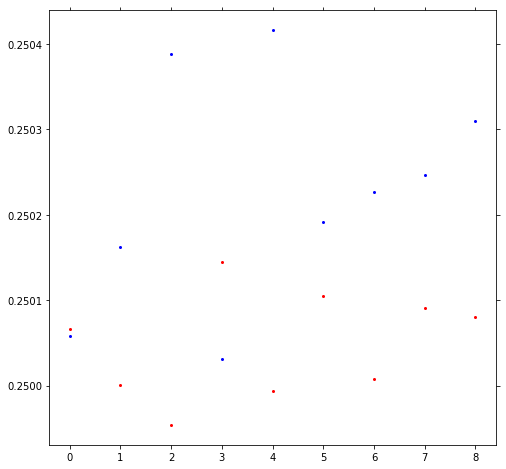

In [16]:
gan.train(clas,  epochs=10, batch_size=40000, sample_interval=2)

In [17]:
SAMPLE_SIZE = clas.shape[0]
gamma, noise, results = detector_filter(SAMPLE_SIZE)
        
results = results*classtd+clasmean

In [18]:
epoch = 10

gamma = results[:, 0]
px = results[:, 1]
py = results[:, 2]
pz = results[:, 3]
pe = results[:, 10]
pipx = results[:, 4]
pipy = results[:, 5]
pipz = results[:, 6]
pipe = results[:, 11]
pimx = results[:, 7]
pimy = results[:, 8]
pimz = results[:, 9]
pime = results[:, 12]
M2pi = pime*pime - pimx*pimx - pimy*pimy - pimz*pimz
ganevents = np.stack([M2pi, gamma, px, pipx, pimx, py, pipy, pimy, pz, pipz, pimz, pe, pipe, pime], axis=1)

gan.generator.save_weights("cmsgeneratorfilter"+str(epoch).zfill(5)+".h5")
gan.discriminator.save_weights("cmsdiscriminatorfilter"+str(epoch).zfill(5)+".h5")

np.save("cmsclasfilter%d.npy"%(epoch), ganevents)